## Prep to run this notebook:
- python scripts/run_vk_ref_geuvadis.py
- python scripts/run_vk_count_ccle.py
- *run notebooks/Fig1_single_cell_analysis.ipynb*

In [1]:
# try:
#     import varseek as vk
# except ImportError:
#     print("varseek not found, installing...")
#     !pip install -U -q varseek
# try:
#     import RLSRWP_2025
# except ImportError:
#     print("RLSRWP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [ ]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import numpy as np
import shutil
import seaborn as sns
import gget
import re
from collections import Counter
import anndata as ad
from scipy import sparse
import scanpy as sc
from sklearn.metrics import silhouette_score
from upsetplot import UpSet, from_contents
from scipy.stats import hypergeom

import varseek as vk
from RLSRWP_2025.constants import box_links_dict

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
data_dir = os.path.join(RLSRWP_2025_dir, "data")

In [ ]:
sequencing_data_out_base = os.path.join(data_dir, "ccle_data_base")
adata_combined_path_variants = os.path.join(sequencing_data_out_base, "adata_vcrs_glioblastoma.h5ad")
# adata_combined_path_reference_genome = os.path.join(sequencing_data_out_base, "adata_vcrs_combined_w37_k41.h5ad")

reference_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
t2g_file = os.path.join(reference_dir, "ensembl_grch37_release113", "t2g.txt")

cosmic_csv = os.path.join(reference_dir, "cosmic", "CancerMutationCensus_AllData_Tsv_v101_GRCh37", "CancerMutationCensus_AllData_v101_GRCh37_mutation_workflow.csv")

out_dir = os.path.join(data_dir, "ccle_analysis")
cbioportal_mutated_genes_path = os.path.join(data_dir, 'vk_count_out_fig1', 'analysis', 'single_cell_analysis', "Mutated_Genes.txt")  # os.path.join(out_dir, "Mutated_Genes.txt")
single_cell_gbm_variants_path = os.path.join(data_dir, 'vk_count_out_fig1', 'analysis', 'single_cell_analysis', 'variants_df_astrocytes.csv')
single_cell_gbm_genes_path = os.path.join(data_dir, 'vk_count_out_fig1', 'analysis', 'single_cell_analysis', 'genes_grouped_df_astrocytes.csv')

min_counts = 2
min_samples_per_variant = 2  # somewhat redundant with fcv_threshold_ccle

# for all of these, do None to get everything
fcv_threshold_ccle = 0.1  # keep in mind there are 38 samples
# fcv_threshold_sc = 0.1
FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio_1p_threshold_sc = 2
max_FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio_1p_threshold_sc = 2
number_cbio_samples = 10

out_dir = os.path.join(data_dir, "ccle_analysis_total")

In [34]:
if not os.path.isfile(adata_combined_path_variants):
    vk.utils.download_box_url(box_links_dict["ccle_glioblastoma_adata_vcrs"], output_file_name=adata_combined_path_variants)
if not os.path.isfile(cosmic_csv):
    gget.cosmic(None, grch_version=37, cosmic_version=101, out=os.path.dirname(cosmic_csv), cosmic_project="cancer", download_cosmic=True, gget_mutate=True, keep_genome_info=True, remove_duplicates=True)
if not os.path.isfile(cbioportal_mutated_genes_path):
    raise FileExistsError(f"{cbioportal_mutated_genes_path} does not exist. Download by visiting https://www.cbioportal.org/study/summary?id=gbm_tcga_pan_can_atlas_2018 → click 'mutated genes'")
if not os.path.isfile(single_cell_gbm_variants_path):
    raise FileExistsError(f"{single_cell_gbm_variants_path} does not exist. Please run Fig1_single_cell_analysis.ipynb to generate this file.")
if not os.path.isfile(single_cell_gbm_genes_path):
    raise FileExistsError(f"{single_cell_gbm_genes_path} does not exist. Please run Fig1_single_cell_analysis.ipynb to generate this file.")

# adata = ad.read_h5ad("/home/jmrich/Desktop/RLSRWP_2025/data/ccle_data_base/adata_vcrs_50.h5ad")  #!!! erase
adata = ad.read_h5ad(adata_combined_path_variants)
cosmic_df = pd.read_csv(cosmic_csv)
cbioportal_mutated_genes_df = pd.read_csv(cbioportal_mutated_genes_path, sep="\t")
cbioportal_mutated_genes_df = cbioportal_mutated_genes_df.sort_values(by="#", ascending=False)
single_cell_gbm_variants_df = pd.read_csv(single_cell_gbm_variants_path)
single_cell_gbm_genes_df = pd.read_csv(single_cell_gbm_genes_path)


os.makedirs(out_dir, exist_ok=True)

In [35]:
# Filter to keep only rows where "#" is >= number_cbio_samples
cbioportal_mutated_genes_df_top = cbioportal_mutated_genes_df[cbioportal_mutated_genes_df["#"] >= number_cbio_samples] if number_cbio_samples is not None else cbioportal_mutated_genes_df.copy()

# only keep columns of adata where adata.var['gene_symbol'] is in cbioportal_mutated_genes_df['Gene'].unique()
cbio_gbm_genes = set(cbioportal_mutated_genes_df_top['Gene'].unique())

In [39]:
adata = ad.read_h5ad(adata_combined_path_variants)

In [40]:
adata = adata[:, ~adata.var_names.str.contains(";")]  # Identify columns (variants) with semicolon in name
adata.var.index.name = "variant_name"
adata.var = adata.var.reset_index(drop=False)
adata.var[["seq_ID", "mutation_cdna"]] = adata.var["variant_name"].str.split(":", expand=True)
adata.var = adata.var.merge(cosmic_df[["seq_ID", "gene_name"]].drop_duplicates("seq_ID"), on="seq_ID", how="left").rename(columns={"gene_name": "gene_symbol"})

if min_counts is not None:
    adata.X = adata.X.multiply(adata.X >= min_counts)

adata = adata[:, np.array((adata.X != 0).sum(axis=0)).flatten() > min_samples_per_variant]  # Identify columns (variants) with non-zero counts across samples

adata.var["number_obs"] = np.array((adata.X != 0).sum(axis=0)).flatten()

adata.var["FCV"] = adata.var["number_obs"] / adata.shape[0]  # fraction of samples with variant - Fraction of cSamples with Variant (FCV)

adata.var['variant_name_with_gene_name'] = (
    adata.var["gene_symbol"] + "(" +
    adata.var["seq_ID"] + "):" +
    adata.var["mutation_cdna"]
)

adata.obs.index = adata.obs.index.astype(str)  # avoid Don’t call _normalize_index with non-categorical/string names
adata.var.index = adata.var.index.astype(str)  # avoid Don’t call _normalize_index with non-categorical/string names

Text(0.5, 1.0, 'Histogram of FCV for variants in CCLE')

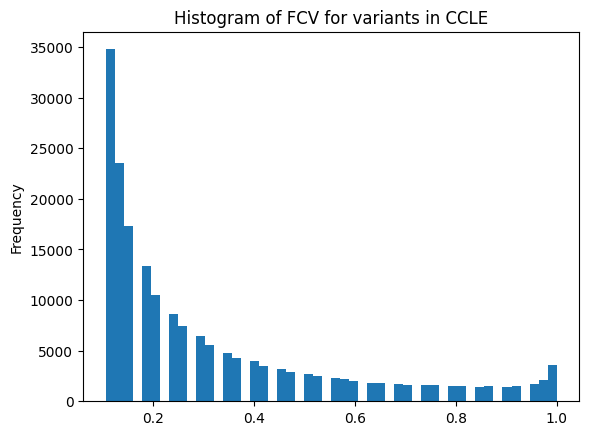

In [127]:
# quick histogram of number_obs
adata.var["FCV"].plot.hist(bins=50).set_title("Histogram of FCV for variants in CCLE")

In [46]:
adata

AnnData object with n_obs × n_vars = 38 × 188083
    obs: 'experiment_alias_underscores_only', 'experiment_accession', 'library_strategy', 'primary_disease', 'subtype_disease', 'sex', 'age', 'lineage_subtype', 'Cellosaurus_NCIt_disease', 'lineage'
    var: 'variant_name', 'seq_ID', 'mutation_cdna', 'gene_symbol', 'number_obs', 'FCV', 'variant_name_with_gene_name'

In [42]:
adata.var.head()

,variant_name,seq_ID,mutation_cdna,gene_symbol,number_obs,FCV,variant_name_with_gene_name
96,ENST00000396153:c.1977A>G,ENST00000396153,c.1977A>G,FAF1,5,0.131579,FAF1(ENST00000396153):c.1977A>G
98,ENST00000396153:c.1363T>G,ENST00000396153,c.1363T>G,FAF1,14,0.368421,FAF1(ENST00000396153):c.1363T>G
324,ENST00000312553:c.102G>A,ENST00000312553,c.102G>A,PODN,8,0.210526,PODN(ENST00000312553):c.102G>A
447,ENST00000312553:c.523G>A,ENST00000312553,c.523G>A,PODN,9,0.236842,PODN(ENST00000312553):c.523G>A
492,ENST00000312553:c.1566T>C,ENST00000312553,c.1566T>C,PODN,4,0.105263,PODN(ENST00000312553):c.1566T>C


In [21]:
single_cell_gbm_variants_df.head()

,variant_name,gene_symbol,variant_count,gene_count,number_obs,FCV,ROLE_IN_CANCER,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name,FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio_1p,simplified_role
0,ENST00000396153:c.1592C>T,FAF1,3.0,49,1,0.000279,NaN,NaN,NaN,ENST00000396153,c.1592C>T,1592,C>T,1592.0,1592.0,ENSG00000185104,ENSG00000185104(ENST00000396153):c.1592C>T,FAF1(ENST00000396153):c.1592C>T,0.04033,NaN
1,ENST00000396153:c.2261A>G,FAF1,5.0,49,2,0.000557,NaN,NaN,NaN,ENST00000396153,c.2261A>G,2261,A>G,2261.0,2261.0,ENSG00000185104,ENSG00000185104(ENST00000396153):c.2261A>G,FAF1(ENST00000396153):c.2261A>G,0.16132,NaN
2,ENST00000396153:c.1823G>A,FAF1,5.0,49,1,0.000279,NaN,NaN,NaN,ENST00000396153,c.1823G>A,1823,G>A,1823.0,1823.0,ENSG00000185104,ENSG00000185104(ENST00000396153):c.1823G>A,FAF1(ENST00000396153):c.1823G>A,0.08066,NaN
3,ENST00000396153:c.1391G>T,FAF1,2.0,49,1,0.000279,NaN,NaN,NaN,ENST00000396153,c.1391G>T,1391,G>T,1391.0,1391.0,ENSG00000185104,ENSG00000185104(ENST00000396153):c.1391G>T,FAF1(ENST00000396153):c.1391G>T,0.08066,NaN
4,ENST00000396153:c.1325C>T,FAF1,3.0,49,1,0.000279,NaN,NaN,NaN,ENST00000396153,c.1325C>T,1325,C>T,1325.0,1325.0,ENSG00000185104,ENSG00000185104(ENST00000396153):c.1325C>T,FAF1(ENST00000396153):c.1325C>T,0.16132,NaN


In [14]:
single_cell_gbm_genes_df.head()

,gene_id,gene_symbol,number_variants_neoplastic_astrocyte,number_variants_healthy_astrocyte,number_variants_total_astrocyte,max_FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio_1p,logfc_neoplastic_to_astrocytes,pvaladj_neoplastic_to_astrocytes
0,ENSG00000000003,TSPAN6,16,2,17,0.725940,0.021156,1.0
1,ENSG00000000419,DPM1,10,2,11,0.241980,0.865096,1.0
2,ENSG00000000457,SCYL3,8,2,10,1.935839,-0.002515,1.0
3,ENSG00000000460,C1orf112,4,0,4,0.161320,0.921615,1.0
4,ENSG00000000938,FGR,0,0,0,0.080660,-1.665242,1.0


In [55]:
ccle_gbm_variants = set(adata.var.loc[adata.var["FCV"] >= fcv_threshold_ccle, "variant_name"]) if fcv_threshold_ccle is not None else set(adata.var["variant_name"])
ccle_gbm_genes = set(adata.var.loc[adata.var["FCV"] >= fcv_threshold_ccle, "gene_symbol"]) if fcv_threshold_ccle is not None else set(adata.var["gene_symbol"])

sc_gbm_variants = set(single_cell_gbm_variants_df.loc[single_cell_gbm_variants_df["FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio_1p"] >= FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio_1p_threshold_sc, "variant_name"]) if FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio_1p_threshold_sc is not None else set(single_cell_gbm_variants_df["variant_name"])
sc_gbm_genes = set(single_cell_gbm_genes_df.loc[single_cell_gbm_genes_df["max_FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio_1p"] >= max_FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio_1p_threshold_sc, "gene_symbol"]) if max_FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio_1p_threshold_sc is not None else set(single_cell_gbm_genes_df["gene_symbol"])

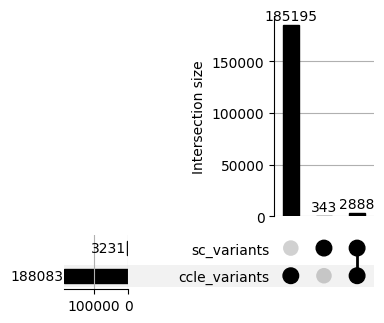

In [56]:
# variants present in both ccle (in a certain fraction of samples) and sc (with certain neoplastic astrocyte to healthy astrocyte ratio)
upset_dict = {
    "ccle_variants": ccle_gbm_variants,
    "sc_variants": sc_gbm_variants,
}

upset_out_path = os.path.join(out_dir, f"upset_variants_detected_{fcv_threshold_ccle}_fcv_threshold_ccle.pdf")
variants_detected_data_for_upset = from_contents(upset_dict)
ax_dict = UpSet(variants_detected_data_for_upset, subset_size='count', show_counts=True).plot()
plt.savefig(upset_out_path)

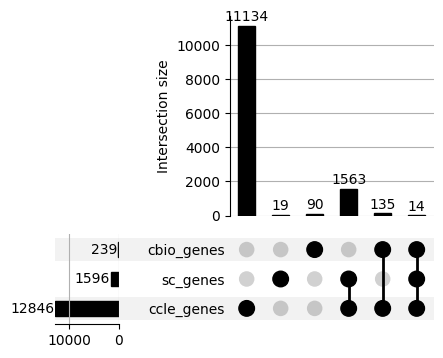

In [57]:
# variants present in ccle (in a certain fraction of samples), sc (with certain max neoplastic astrocyte to healthy astrocyte ratio), and cbio (in a certain number of samples)
upset_dict = {
    "ccle_genes": ccle_gbm_genes,
    "sc_genes": sc_gbm_genes,
    "cbio_genes": cbio_gbm_genes,
}

upset_out_path = os.path.join(out_dir, f"upset_genes_detected_{fcv_threshold_ccle}_fcv_threshold_ccle.pdf")
variants_detected_data_for_upset = from_contents(upset_dict)
ax_dict = UpSet(variants_detected_data_for_upset, subset_size='count', show_counts=True).plot()
plt.savefig(upset_out_path)

## set fcv_threshold_ccle higher and try again

In [ ]:
# fcv_threshold_ccle2 = 0.2

# ccle_gbm_variants2 = set(adata.var.loc[adata.var["FCV"] >= fcv_threshold_ccle2, "variant_name"]) if fcv_threshold_ccle2 is not None else set(adata.var["variant_name"])
# ccle_gbm_genes2 = set(adata.var.loc[adata.var["FCV"] >= fcv_threshold_ccle2, "gene_symbol"]) if fcv_threshold_ccle2 is not None else set(adata.var["gene_symbol"])

# sc_gbm_variants2 = set(single_cell_gbm_variants_df.loc[single_cell_gbm_variants_df["FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio_1p"] >= FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio_1p_threshold_sc, "variant_name"]) if FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio_1p_threshold_sc is not None else set(single_cell_gbm_variants_df["variant_name"])
# sc_gbm_genes2 = set(single_cell_gbm_genes_df.loc[single_cell_gbm_genes_df["max_FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio_1p"] >= max_FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio_1p_threshold_sc, "gene_symbol"]) if max_FCV_neoplastic_astrocyte_to_FCV_healthy_astrocyte_ratio_1p_threshold_sc is not None else set(single_cell_gbm_genes_df["gene_symbol"])

# # variants present in both ccle (in a certain fraction of samples) and sc (with certain neoplastic astrocyte to healthy astrocyte ratio)
# upset_dict = {
#     "ccle_variants": ccle_gbm_variants2,
#     "sc_variants": sc_gbm_variants2,
# }

# upset_out_path = os.path.join(out_dir, f"upset_variants_detected_{fcv_threshold_ccle2}_fcv_threshold_ccle.pdf")
# variants_detected_data_for_upset = from_contents(upset_dict)
# ax_dict = UpSet(variants_detected_data_for_upset, subset_size='count', show_counts=True).plot()
# plt.savefig(upset_out_path)

# # variants present in ccle (in a certain fraction of samples), sc (with certain max neoplastic astrocyte to healthy astrocyte ratio), and cbio (in a certain number of samples)
# upset_dict = {
#     "ccle_genes": ccle_gbm_genes2,
#     "sc_genes": sc_gbm_genes2,
#     "cbio_genes": cbio_gbm_genes,
# }

# upset_out_path = os.path.join(out_dir, f"upset_genes_detected_{fcv_threshold_ccle2}_fcv_threshold_ccle.pdf")
# variants_detected_data_for_upset = from_contents(upset_dict)
# ax_dict = UpSet(variants_detected_data_for_upset, subset_size='count', show_counts=True).plot()
# plt.savefig(upset_out_path)

## How much of this is by chance?

In [61]:
total_variants_cosmic_cmc = len(cosmic_df)
total_genes_cosmic_cmc = len(cosmic_df['gene_name'].unique())

total_variants_ccle_gbm = len(ccle_gbm_variants)
total_genes_ccle_gbm = len(ccle_gbm_genes)

total_variants_sc = len(sc_gbm_variants)
total_genes_sc = len(sc_gbm_genes)

variant_overlap_between_ccle_and_sc = len(ccle_gbm_variants.intersection(sc_gbm_variants))
gene_overlap_between_ccle_and_sc = len(ccle_gbm_genes.intersection(sc_gbm_genes))

In [83]:
def compute_overlap_p_value(N, n1, n2, observed_overlap, element_name = "element"):
    """
    N: population size (e.g., total number of variants/genes in cosmic_cmc)
    n1: sample size 1 (e.g., number of variants/genes in ccle)
    n2: sample size 2 (e.g., number of variants/genes in sc)
    """
    print(f"""element name: {element_name}
N (population size): {N}
n1 (sample size 1): {n1}
n2 (sample size 2): {n2}
""")

    expected_overlap = (n1 * n2) / N
    print(f"Expected {element_name} overlap: {expected_overlap}")
    print(f"Observed {element_name} overlap: {observed_overlap}")

    # Hypergeometric distribution
    rv = hypergeom(N, n1, n2)

    # Compute p-value (right-tail)
    p_value = rv.sf(observed_overlap - 1)

    if p_value == 0:
        print(f"Right-tail p-value for observed {element_name} overlap {observed_overlap}: <1e-308")
    else:
        print(f"Right-tail p-value for observed {element_name} overlap {observed_overlap}: {p_value:.4g}")

    return p_value


compute_overlap_p_value(
    N=total_variants_cosmic_cmc,
    n1=total_variants_ccle_gbm,
    n2=total_variants_sc,
    observed_overlap=variant_overlap_between_ccle_and_sc,
    element_name = "variant"
)

print("--------------------------")

compute_overlap_p_value(
    N=total_genes_cosmic_cmc,
    n1=total_genes_ccle_gbm,
    n2=total_genes_sc,
    observed_overlap=gene_overlap_between_ccle_and_sc,
    element_name = "gene"
)

element name: variant
N (population size): 5419494
n1 (sample size 1): 188083
n2 (sample size 2): 3231

Expected variant overlap: 112.13153349740769
Observed variant overlap: 2888
Right-tail p-value for observed variant overlap 2888: <1e-308
--------------------------
element name: gene
N (population size): 19993
n1 (sample size 1): 12846
n2 (sample size 2): 1596

Expected gene overlap: 1025.46971440004
Observed gene overlap: 1577
Right-tail p-value for observed gene overlap 1577: 7.046e-284


7.046147198928731e-284

Safe to say it's not by chance...

## Let's look at those intersecting genes

In [119]:
gene_intersection = sorted(ccle_gbm_genes & sc_gbm_genes & cbio_gbm_genes)
print(gene_intersection)

['AHNAK2', 'C3', 'COL1A2', 'EGFR', 'KANK1', 'KMT2C', 'LAMA5', 'NAV2', 'PDGFRA', 'PTPRZ1', 'SAMD9', 'SYNE2', 'THBS1', 'TP53']


## How about the variants?

In [128]:
variant_intersection = sorted(ccle_gbm_variants & sc_gbm_variants)
filtered_df = adata.var[adata.var["variant_name"].isin(variant_intersection)].copy()

### Look at the variants that intersect sc and CCLE, and sort by the fraction of samples in which each variant is present in CCLE

In [130]:
filtered_df.head()

,variant_name,seq_ID,mutation_cdna,gene_symbol,number_obs,FCV,variant_name_with_gene_name
1773,ENST00000371218:c.313T>G,ENST00000371218,c.313T>G,FGGY,26,0.684211,FGGY(ENST00000371218):c.313T>G
2132,ENST00000371083:c.1083C>T,ENST00000371083,c.1083C>T,PGM1,20,0.526316,PGM1(ENST00000371083):c.1083C>T
3782,ENST00000370751:c.397A>G,ENST00000370751,c.397A>G,IFI44L,20,0.526316,IFI44L(ENST00000370751):c.397A>G
4876,ENST00000370192:c.186C>T,ENST00000370192,c.186C>T,DPYD,36,0.947368,DPYD(ENST00000370192):c.186C>T
15487,ENST00000376957:c.183A>G,ENST00000376957,c.183A>G,SRM,38,1.000000,SRM(ENST00000376957):c.183A>G


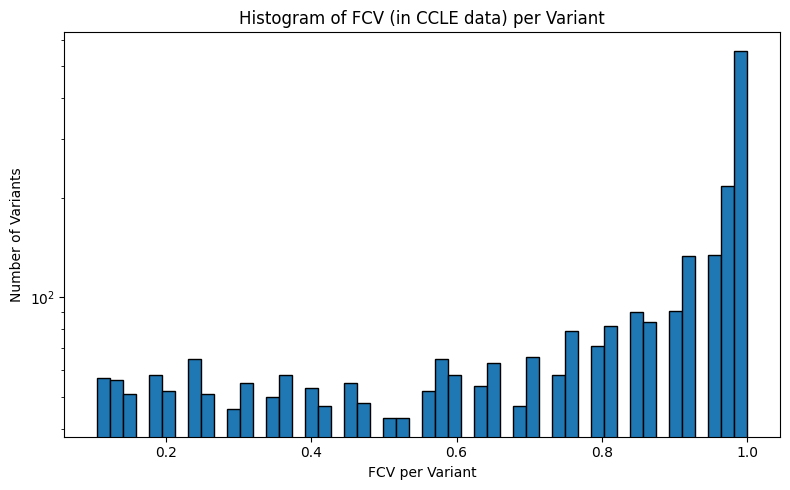

In [129]:
plt.figure(figsize=(8,5))
plt.hist(filtered_df["FCV"].dropna(), bins=50, edgecolor='black')
plt.xlabel("FCV per Variant")
plt.yscale('log')
plt.ylabel("Number of Variants")
plt.title("Histogram of FCV (in CCLE data) per Variant")
plt.tight_layout()
plt.show()

In [137]:
FCV_threshold_tmp = 0.9

high_fcv_df = filtered_df[filtered_df["FCV"] >= FCV_threshold_tmp]
high_fcv_genes = set(high_fcv_df["gene_symbol"])

print(f"Number of variants both with tumor specificity in single cell data AND with CCLE FCV >= {FCV_threshold_tmp}: {len(high_fcv_df)}")
print(f"Number of genes both with tumor specificity in single cell data AND with CCLE FCV >= {FCV_threshold_tmp}: {len(high_fcv_genes)}")
# print(high_fcv_genes)

high_fcv_genes_also_in_cbio = high_fcv_genes & cbio_gbm_genes
print(f"Number of genes with tumor specificity in single cell data AND CCLE FCV >= {FCV_threshold_tmp} AND also in cBioPortal: {len(high_fcv_genes_also_in_cbio)}")
print(high_fcv_genes_also_in_cbio)

Number of variants both with tumor specificity in single cell data AND with CCLE FCV >= 0.9: 1040
Number of genes both with tumor specificity in single cell data AND with CCLE FCV >= 0.9: 480
Number of genes with tumor specificity in single cell data AND CCLE FCV >= 0.9 AND also in cBioPortal: 4
{'NAV2', 'LAMA5', 'COL1A2', 'PDGFRA'}


### Look at the variants that intersect sc and CCLE, and sort by number of variants in each gene

In [122]:
gene_counts = filtered_df["gene_symbol"].value_counts()

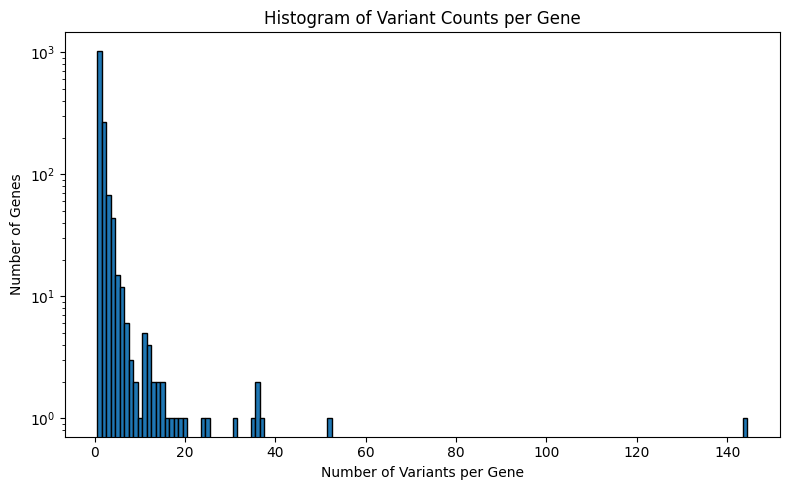

In [123]:
plt.figure(figsize=(8, 5))
plt.hist(gene_counts, bins=range(1, gene_counts.max() + 2), edgecolor='black', align='left')
plt.xlabel("Number of Variants per Gene")
plt.yscale('log')
plt.ylabel("Number of Genes")
plt.title("Histogram of Variant Counts per Gene")
# plt.xticks(range(1, gene_counts.max() + 1))
plt.tight_layout()
plt.show()

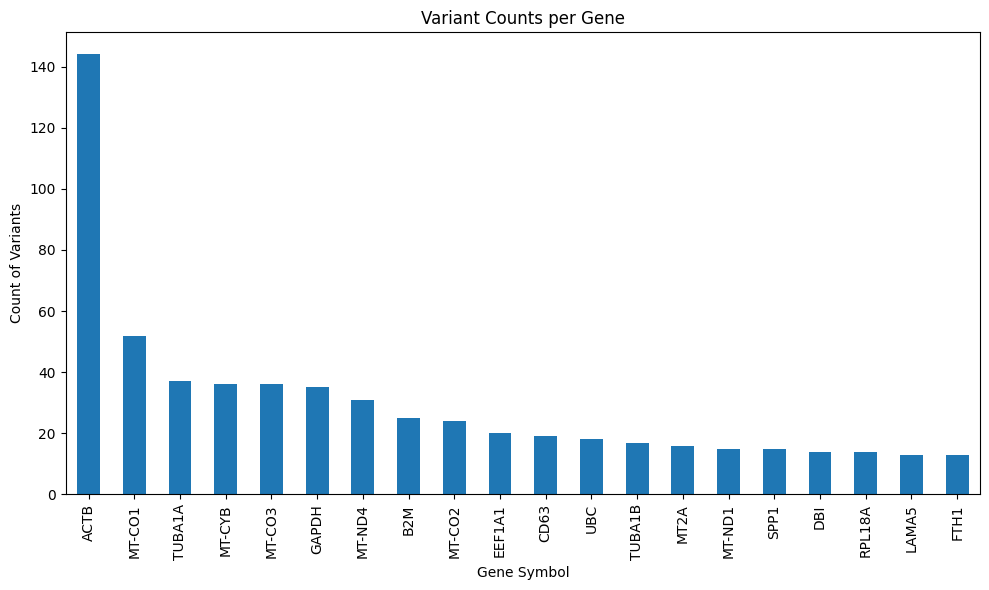

In [124]:
number_to_plot = 20

plt.figure(figsize=(10, 6))
gene_counts.sort_values(ascending=False).head(number_to_plot).plot.bar()
plt.xlabel("Gene Symbol")
plt.ylabel("Count of Variants")
plt.title("Variant Counts per Gene")
plt.tight_layout()
plt.show()

## Only the cbio ones

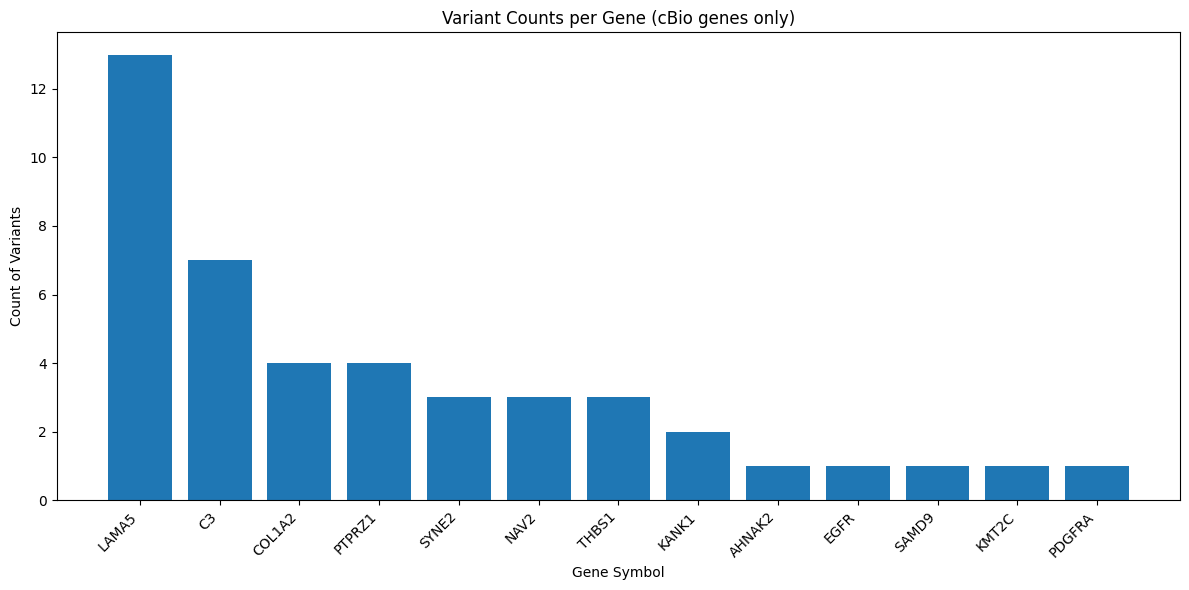

In [125]:
number_to_plot = 20

gene_counts_df = gene_counts.rename("count").reset_index()
gene_counts_df.rename(columns={"index": "gene_symbol"}, inplace=True)
gene_counts_df["in_cbio"] = gene_counts_df["gene_symbol"].isin(cbio_gbm_genes)
cbio_genes_df = gene_counts_df[gene_counts_df["in_cbio"]]

top_cbio_genes_df = cbio_genes_df.sort_values("count", ascending=False).head(number_to_plot)
plt.figure(figsize=(12, 6))
plt.bar(top_cbio_genes_df["gene_symbol"], top_cbio_genes_df["count"])
plt.xlabel("Gene Symbol")
plt.ylabel("Count of Variants")
plt.title("Variant Counts per Gene (cBio genes only)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()